# **Import Packages**

In [1]:
import os
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, random_split
import torchvision.models as models
import matplotlib.pyplot as plt
import numpy as np
import torchvision

# **Data Augmentation**

In [2]:
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),   # zoom in/out
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),                        # vertical flip
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [3]:
transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [4]:
DATASET_DIR = r"C:\Users\HP\OneDrive\Documents\Project\Project 5\Solar Panel"
print("Classes detected:", os.listdir(DATASET_DIR))

Classes detected: ['Bird-drop', 'Clean', 'Dusty', 'Electrical-damage', 'Physical-Damage', 'Snow-Covered']


In [5]:
full_dataset = datasets.ImageFolder(root=DATASET_DIR, transform=transform_train)

In [6]:
train_size = int(0.7 * len(full_dataset))
val_size = int(0.15 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size

In [7]:
train_dataset, val_dataset, test_dataset = random_split(
    full_dataset, [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(42)
)

In [8]:
val_dataset.dataset.transform = transform_test
test_dataset.dataset.transform = transform_test

In [9]:
train_loader = DataLoader(dataset=train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=8, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=8, shuffle=False)

print(f"Train: {len(train_dataset)} | Val: {len(val_dataset)} | Test: {len(test_dataset)}")
print("Classes:", full_dataset.classes)

Train: 619 | Val: 132 | Test: 134
Classes: ['Bird-drop', 'Clean', 'Dusty', 'Electrical-damage', 'Physical-Damage', 'Snow-Covered']


In [10]:
def imshow(img, title=None):
    img = img.numpy().transpose((1, 2, 0))
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    img = std * img + mean  # unnormalize
    img = img.clip(0, 1)
    plt.imshow(img)
    if title is not None:
        plt.title(title)
    plt.axis("off")
    plt.show()

In [11]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

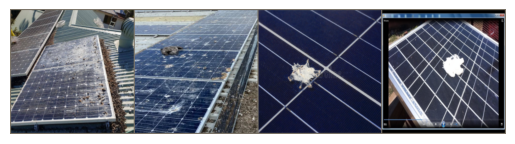

Bird-drop Bird-drop Bird-drop Bird-drop


In [12]:
imshow(torchvision.utils.make_grid(images[:4]))
print(' '.join(f'{full_dataset.classes[labels[j]]}' for j in range(4)))

# **Model Building**

## **Simple CNN**

In [18]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=6):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Sequential(nn.Conv2d(3, 16, 3, padding=1), nn.BatchNorm2d(16), nn.ReLU(), nn.MaxPool2d(2))
        self.conv2 = nn.Sequential(nn.Conv2d(16, 32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(), nn.MaxPool2d(2))
        self.conv3 = nn.Sequential(nn.Conv2d(32, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(), nn.MaxPool2d(2))
        self.conv4 = nn.Sequential(nn.Conv2d(64, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(), nn.MaxPool2d(2))
        self.conv5 = nn.Sequential(nn.Conv2d(128, 256, 3, padding=1), nn.BatchNorm2d(256), nn.ReLU(), nn.MaxPool2d(2))
        self.gap = nn.AdaptiveAvgPool2d((1,1))
        self.fc1 = nn.Linear(256, 128)
        self.fc2 = nn.Linear(128, num_classes)
        self.dropout = nn.Dropout(0.6)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.gap(x)
        x = torch.flatten(x, 1)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [20]:
num_classes = 6 
model = SimpleCNN(num_classes=num_classes)
print("✅ SimpleCNN:\n", model)

✅ SimpleCNN:
 SimpleCNN(
  (conv1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    

In [21]:
criterion = nn.CrossEntropyLoss()   
optimizer = optim.AdamW(model.parameters(), lr=5e-5, weight_decay=5e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

In [22]:
num_epochs = 10
best_val_acc = 0.0
save_path = "SimpleCNN.pth"

for epoch in range(num_epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)  # gradient clipping
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (preds == labels).sum().item()

    train_acc = 100 * correct / total
    train_loss = running_loss / len(train_loader)

    # Validation
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (preds == labels).sum().item()

    val_acc = 100 * val_correct / val_total
    val_loss = val_loss / len(val_loader)

    # Scheduler step
    scheduler.step(val_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), save_path)
        print(f"✅ Saved Best Model with Acc: {best_val_acc:.2f}%")

Epoch [1/10] Train Loss: 1.6617, Train Acc: 31.34% | Val Loss: 1.4405, Val Acc: 53.79%
✅ Saved Best Model with Acc: 53.79%
Epoch [2/10] Train Loss: 1.5127, Train Acc: 44.59% | Val Loss: 1.3204, Val Acc: 55.30%
✅ Saved Best Model with Acc: 55.30%
Epoch [3/10] Train Loss: 1.3987, Train Acc: 50.89% | Val Loss: 1.2276, Val Acc: 57.58%
✅ Saved Best Model with Acc: 57.58%
Epoch [4/10] Train Loss: 1.3114, Train Acc: 55.57% | Val Loss: 1.1380, Val Acc: 60.61%
✅ Saved Best Model with Acc: 60.61%
Epoch [5/10] Train Loss: 1.2619, Train Acc: 55.09% | Val Loss: 1.1005, Val Acc: 64.39%
✅ Saved Best Model with Acc: 64.39%
Epoch [6/10] Train Loss: 1.2566, Train Acc: 53.31% | Val Loss: 1.0658, Val Acc: 62.88%
Epoch [7/10] Train Loss: 1.2037, Train Acc: 58.32% | Val Loss: 1.0318, Val Acc: 63.64%
Epoch [8/10] Train Loss: 1.1863, Train Acc: 60.90% | Val Loss: 0.9956, Val Acc: 68.94%
✅ Saved Best Model with Acc: 68.94%
Epoch [9/10] Train Loss: 1.1453, Train Acc: 60.42% | Val Loss: 0.9811, Val Acc: 71.97%
✅

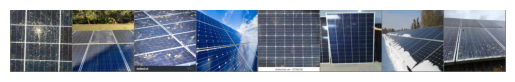

Predicted:  Bird-drop Clean Bird-drop Clean Bird-drop Clean Snow-Covered Bird-drop


In [23]:
# Visualize predictions on a few test images
dataiter = iter(test_loader)
images, labels = next(dataiter)

# Predict
images, labels = images.to(device), labels.to(device)
outputs = model(images)
_, predicted = torch.max(outputs, 1)

# Map predictions to class names
predicted_classes = [full_dataset.classes[p.item()] for p in predicted[:8]]

# Show images and predictions
imshow(torchvision.utils.make_grid(images.cpu()[:8]))
print('Predicted: ', ' '.join(predicted_classes))

In [24]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Make sure to load the best model
model.load_state_dict(torch.load("SimpleCNN.pth"))
model.to(device)
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute metrics
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')
f1 = f1_score(all_labels, all_preds, average='weighted')

print(f"Accuracy:  {accuracy*100:.2f}%")
print(f"Precision: {precision*100:.2f}%")
print(f"Recall:    {recall*100:.2f}%")
print(f"F1-score:  {f1*100:.2f}%")

Accuracy:  64.93%
Precision: 67.62%
Recall:    64.93%
F1-score:  62.86%


## **ResNet18**

In [31]:
from torchvision.models import resnet18, ResNet18_Weights

In [43]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [44]:
data_dir = r"C:\Users\HP\OneDrive\Documents\Project\Project 5\Solar Panel"

In [45]:
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [46]:
transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [47]:
full_dataset = datasets.ImageFolder(data_dir, transform=transform_train)
num_classes = len(full_dataset.classes)
print("Classes:", full_dataset.classes)

# Train/Val split (80%/20%)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])
val_dataset.dataset.transform = transform_test

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=2)

Classes: ['Bird-drop', 'Clean', 'Dusty', 'Electrical-damage', 'Physical-Damage', 'Snow-Covered']


In [49]:
def build_resnet(num_classes=6, freeze_backbone=True):
    weights = ResNet18_Weights.DEFAULT
    model_1 = resnet18(weights=weights)
    
    if freeze_backbone:
        for param in model_1.parameters():
            param.requires_grad = False
            
    in_features = model_1.fc.in_features
    model_1.fc = nn.Sequential(
        nn.Dropout(p=0.3),  
        nn.Linear(in_features, num_classes)
    )
    return model_1

In [50]:
model_1 = build_resnet(num_classes=num_classes, freeze_backbone=True).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model_1.parameters()), lr=1e-3, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, threshold=0.01)

In [51]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs, save_path):
    best_acc = 0.0
    for epoch in range(num_epochs):
        # ---- Training ----
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()
            
        train_loss = running_loss / len(train_loader)
        train_acc = 100 * correct / total
        
        # ---- Validation ----
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (preds == labels).sum().item()
        val_loss /= len(val_loader)
        val_acc = 100 * val_correct / val_total
        
        scheduler.step(val_loss)
        
        print(f"Epoch [{epoch+1}/{num_epochs}] "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
        
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), save_path)
            print(f"✅ Saved Best Model with Acc: {best_acc:.2f}%")
    
    return best_acc

In [59]:
print("Training model test")
best_acc = train_model(model_1, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=5, save_path="resnet_test.pth")

Training model test
Epoch [1/5] Train Loss: 0.0107, Train Acc: 99.72% | Val Loss: 0.4376, Val Acc: 87.01%
✅ Saved Best Model with Acc: 87.01%
Epoch [2/5] Train Loss: 0.0119, Train Acc: 99.72% | Val Loss: 0.3980, Val Acc: 88.70%
✅ Saved Best Model with Acc: 88.70%
Epoch [3/5] Train Loss: 0.0116, Train Acc: 99.86% | Val Loss: 0.4065, Val Acc: 87.01%
Epoch [4/5] Train Loss: 0.0170, Train Acc: 99.72% | Val Loss: 0.3736, Val Acc: 88.14%
Epoch [5/5] Train Loss: 0.0082, Train Acc: 99.86% | Val Loss: 0.4605, Val Acc: 88.14%


In [60]:
for param in model_1.parameters():
    param.requires_grad = True

optimizer = optim.AdamW(model_1.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, threshold=0.01)

print("Fine-tuning full model")
Fine_tuning_model = train_model(model_1, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=15, save_path="Resnet18.pth")

print(f"✅ Best validation accuracy after fine-tuning: {Fine_tuning_model:.2f}%")

Fine-tuning full model
Epoch [1/15] Train Loss: 0.0217, Train Acc: 99.29% | Val Loss: 0.3575, Val Acc: 89.83%
✅ Saved Best Model with Acc: 89.83%
Epoch [2/15] Train Loss: 0.0290, Train Acc: 99.15% | Val Loss: 0.4922, Val Acc: 88.14%
Epoch [3/15] Train Loss: 0.0662, Train Acc: 98.45% | Val Loss: 0.4213, Val Acc: 88.14%
Epoch [4/15] Train Loss: 0.1041, Train Acc: 97.03% | Val Loss: 0.3909, Val Acc: 87.57%
Epoch [5/15] Train Loss: 0.1007, Train Acc: 98.02% | Val Loss: 0.4467, Val Acc: 87.01%
Epoch [6/15] Train Loss: 0.0747, Train Acc: 97.60% | Val Loss: 0.4879, Val Acc: 85.31%
Epoch [7/15] Train Loss: 0.0340, Train Acc: 98.59% | Val Loss: 0.5717, Val Acc: 84.18%
Epoch [8/15] Train Loss: 0.0142, Train Acc: 99.86% | Val Loss: 0.5075, Val Acc: 85.31%
Epoch [9/15] Train Loss: 0.0167, Train Acc: 99.72% | Val Loss: 0.4908, Val Acc: 86.44%
Epoch [10/15] Train Loss: 0.0304, Train Acc: 99.58% | Val Loss: 0.4836, Val Acc: 86.44%
Epoch [11/15] Train Loss: 0.0134, Train Acc: 99.44% | Val Loss: 0.4440

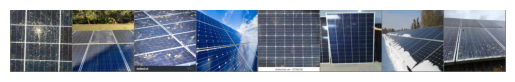

Predicted:  Physical-Damage Bird-drop Bird-drop Clean Dusty Clean Snow-Covered Bird-drop


In [61]:
# Visualize predictions on a few test images
dataiter = iter(test_loader)
images, labels = next(dataiter)

# Predict
images, labels = images.to(device), labels.to(device)
outputs = model_1(images)
_, predicted = torch.max(outputs, 1)

# Map predictions to class names
predicted_classes = [full_dataset.classes[p.item()] for p in predicted[:8]]

# Show images and predictions
imshow(torchvision.utils.make_grid(images.cpu()[:8]))
print('Predicted: ', ' '.join(predicted_classes))

In [62]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Make sure to load the best model
model_1.load_state_dict(torch.load("Resnet18.pth"))
model_1.to(device)
model_1.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model_1(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute metrics
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')
f1 = f1_score(all_labels, all_preds, average='weighted')

print(f"Accuracy:  {accuracy*100:.2f}%")
print(f"Precision: {precision*100:.2f}%")
print(f"Recall:    {recall*100:.2f}%")
print(f"F1-score:  {f1*100:.2f}%")

Accuracy:  96.27%
Precision: 96.41%
Recall:    96.27%
F1-score:  96.27%


## **EfficientNet**

In [63]:
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights

In [65]:
def build_efficientnet(num_classes=6, freeze_backbone=False):
    weights = EfficientNet_B0_Weights.DEFAULT
    model_2 = efficientnet_b0(weights=weights)

    if freeze_backbone:
        for param in model_2.features.parameters():
            param.requires_grad = False

    in_features = model_2.classifier[1].in_features
    model_2.classifier = nn.Sequential(
        nn.Dropout(p=0.3),
        nn.Linear(in_features, num_classes)
    )
    return model_2

In [66]:
model_2 = build_efficientnet(num_classes=num_classes, freeze_backbone=False).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model_2.parameters()), lr=1e-3, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, threshold=0.01)

In [67]:
print("Training model test")
Eff_Model = train_model(model_2, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=5, save_path="efficientnet_test.pth")

Training model test
Epoch [1/5] Train Loss: 1.0731, Train Acc: 61.72% | Val Loss: 0.7180, Val Acc: 76.27%
✅ Saved Best Model with Acc: 76.27%
Epoch [2/5] Train Loss: 0.5394, Train Acc: 83.33% | Val Loss: 0.4993, Val Acc: 80.23%
✅ Saved Best Model with Acc: 80.23%
Epoch [3/5] Train Loss: 0.3470, Train Acc: 88.70% | Val Loss: 0.2994, Val Acc: 88.14%
✅ Saved Best Model with Acc: 88.14%
Epoch [4/5] Train Loss: 0.3566, Train Acc: 89.41% | Val Loss: 0.4662, Val Acc: 84.75%
Epoch [5/5] Train Loss: 0.2644, Train Acc: 91.81% | Val Loss: 0.5492, Val Acc: 84.75%


In [68]:
for param in model_2.parameters():
    param.requires_grad = True

optimizer = optim.AdamW(model_2.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, threshold=0.01)

print("Fine-tuning full model")
Fine_tuning_model_2 = train_model(model_2, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=15, save_path="Efficientnet.pth")

print(f"✅ Best validation accuracy after fine-tuning: {Fine_tuning_model_2:.2f}%")

Fine-tuning full model
Epoch [1/15] Train Loss: 0.1638, Train Acc: 96.33% | Val Loss: 0.4059, Val Acc: 88.14%
✅ Saved Best Model with Acc: 88.14%
Epoch [2/15] Train Loss: 0.1143, Train Acc: 96.19% | Val Loss: 0.4224, Val Acc: 90.40%
✅ Saved Best Model with Acc: 90.40%
Epoch [3/15] Train Loss: 0.0592, Train Acc: 98.59% | Val Loss: 0.5512, Val Acc: 89.83%
Epoch [4/15] Train Loss: 0.0556, Train Acc: 98.59% | Val Loss: 0.3839, Val Acc: 91.53%
✅ Saved Best Model with Acc: 91.53%
Epoch [5/15] Train Loss: 0.0554, Train Acc: 98.87% | Val Loss: 0.5016, Val Acc: 90.96%
Epoch [6/15] Train Loss: 0.0388, Train Acc: 99.72% | Val Loss: 0.4241, Val Acc: 89.83%
Epoch [7/15] Train Loss: 0.0707, Train Acc: 97.74% | Val Loss: 0.4573, Val Acc: 89.27%
Epoch [8/15] Train Loss: 0.0514, Train Acc: 98.73% | Val Loss: 0.3933, Val Acc: 92.09%
✅ Saved Best Model with Acc: 92.09%
Epoch [9/15] Train Loss: 0.0367, Train Acc: 99.15% | Val Loss: 0.4324, Val Acc: 89.83%
Epoch [10/15] Train Loss: 0.0264, Train Acc: 99.29

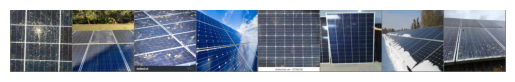

Predicted:  Physical-Damage Bird-drop Bird-drop Clean Dusty Clean Snow-Covered Bird-drop


In [69]:
# Visualize predictions on a few test images
dataiter = iter(test_loader)
images, labels = next(dataiter)

# Predict
images, labels = images.to(device), labels.to(device)
outputs = model_2(images)
_, predicted = torch.max(outputs, 1)

# Map predictions to class names
predicted_classes = [full_dataset.classes[p.item()] for p in predicted[:8]]

# Show images and predictions
imshow(torchvision.utils.make_grid(images.cpu()[:8]))
print('Predicted: ', ' '.join(predicted_classes))

In [71]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Make sure to load the best model
model_2.load_state_dict(torch.load("Efficientnet.pth"))
model_2.to(device)
model_2.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model_2(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute metrics
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')
f1 = f1_score(all_labels, all_preds, average='weighted')

print(f"Accuracy:  {accuracy*100:.2f}%")
print(f"Precision: {precision*100:.2f}%")
print(f"Recall:    {recall*100:.2f}%")
print(f"F1-score:  {f1*100:.2f}%")

Accuracy:  97.76%
Precision: 97.78%
Recall:    97.76%
F1-score:  97.75%


## **MobileNet**

In [72]:
from torchvision.models import mobilenet_v2, MobileNet_V2_Weights

In [73]:
def build_mobilenet(num_classes=6, freeze_backbone=False):
    weights = MobileNet_V2_Weights.DEFAULT
    model_3 = mobilenet_v2(weights=weights)

    # Optionally freeze backbone
    if freeze_backbone:
        for param in model_3.features.parameters():
            param.requires_grad = False

    # Replace classifier
    in_features = model_3.classifier[1].in_features
    model_3.classifier = nn.Sequential(
        nn.Dropout(p=0.3),
        nn.Linear(in_features, num_classes)
    )

    return model_3

In [74]:
model_3 = build_mobilenet(num_classes=num_classes, freeze_backbone=False).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model_3.parameters()), lr=1e-3, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, threshold=0.01)

In [75]:
print("Training model test")
Mob_Model = train_model(model_3, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=5, save_path="mobilenet_test.pth")

Training model test
Epoch [1/5] Train Loss: 0.9240, Train Acc: 69.49% | Val Loss: 0.7658, Val Acc: 76.27%
✅ Saved Best Model with Acc: 76.27%
Epoch [2/5] Train Loss: 0.5380, Train Acc: 82.63% | Val Loss: 0.3894, Val Acc: 87.57%
✅ Saved Best Model with Acc: 87.57%
Epoch [3/5] Train Loss: 0.3764, Train Acc: 87.85% | Val Loss: 0.6535, Val Acc: 77.97%
Epoch [4/5] Train Loss: 0.4389, Train Acc: 85.17% | Val Loss: 0.3785, Val Acc: 87.57%
Epoch [5/5] Train Loss: 0.2670, Train Acc: 92.66% | Val Loss: 0.3077, Val Acc: 91.53%
✅ Saved Best Model with Acc: 91.53%


In [76]:
for param in model_3.parameters():
    param.requires_grad = True

optimizer = optim.AdamW(model_3.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, threshold=0.01)

print("Fine-tuning full model")
Fine_tuning_model_3 = train_model(model_3, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=15, save_path="MobileNet.pth")

print(f"✅ Best validation accuracy after fine-tuning: {Fine_tuning_model_3:.2f}%")

Fine-tuning full model
Epoch [1/15] Train Loss: 0.1209, Train Acc: 96.89% | Val Loss: 0.3201, Val Acc: 92.09%
✅ Saved Best Model with Acc: 92.09%
Epoch [2/15] Train Loss: 0.0484, Train Acc: 99.01% | Val Loss: 0.3135, Val Acc: 92.66%
✅ Saved Best Model with Acc: 92.66%
Epoch [3/15] Train Loss: 0.0409, Train Acc: 98.87% | Val Loss: 0.3417, Val Acc: 91.53%
Epoch [4/15] Train Loss: 0.0469, Train Acc: 99.15% | Val Loss: 0.3730, Val Acc: 91.53%
Epoch [5/15] Train Loss: 0.0584, Train Acc: 98.73% | Val Loss: 0.3442, Val Acc: 91.53%
Epoch [6/15] Train Loss: 0.0537, Train Acc: 98.73% | Val Loss: 0.3163, Val Acc: 91.53%
Epoch [7/15] Train Loss: 0.0350, Train Acc: 99.29% | Val Loss: 0.3397, Val Acc: 92.09%
Epoch [8/15] Train Loss: 0.0307, Train Acc: 99.29% | Val Loss: 0.3363, Val Acc: 91.53%
Epoch [9/15] Train Loss: 0.0252, Train Acc: 99.58% | Val Loss: 0.3400, Val Acc: 91.53%
Epoch [10/15] Train Loss: 0.0198, Train Acc: 99.72% | Val Loss: 0.3226, Val Acc: 91.53%
Epoch [11/15] Train Loss: 0.0185, 

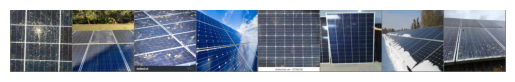

Predicted:  Physical-Damage Bird-drop Bird-drop Clean Dusty Clean Snow-Covered Bird-drop


In [78]:
# Visualize predictions on a few test images
dataiter = iter(test_loader)
images, labels = next(dataiter)

# Predict
images, labels = images.to(device), labels.to(device)
outputs = model_3(images)
_, predicted = torch.max(outputs, 1)

# Map predictions to class names
predicted_classes = [full_dataset.classes[p.item()] for p in predicted[:8]]

# Show images and predictions
imshow(torchvision.utils.make_grid(images.cpu()[:8]))
print('Predicted: ', ' '.join(predicted_classes))

In [79]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Make sure to load the best model
model_3.load_state_dict(torch.load("MobileNet.pth"))
model_3.to(device)
model_3.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model_3(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute metrics
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')
f1 = f1_score(all_labels, all_preds, average='weighted')

print(f"Accuracy:  {accuracy*100:.2f}%")
print(f"Precision: {precision*100:.2f}%")
print(f"Recall:    {recall*100:.2f}%")
print(f"F1-score:  {f1*100:.2f}%")

Accuracy:  98.51%
Precision: 98.55%
Recall:    98.51%
F1-score:  98.49%
